# Load the packages

In [1]:
rm(list = ls())
setwd('C:/Users/Tao/Desktop/KNN')

In [2]:
pkgs <- c('dplyr', 'ggplot2', 'class', 'caret', 'pROC', 'Hmisc')
# install.packages(pkgs)
suppressMessages(for (i in pkgs) library(i, character.only = TRUE))

# Load the data

In [3]:
load(file = 'simulated_dataset.R')
str(dataset_final)

'data.frame':	8000 obs. of  21 variables:
 $ ID      : num  1 2 3 4 5 6 7 8 9 10 ...
 $ X_1     : num  56 63 67 50 64 65 59 59 59 58 ...
 $ X_2     : num  0 0 1 1 0 0 0 0 0 0 ...
 $ X_3     : num  15.4 14.8 28.5 23.3 17.9 18.9 20.8 14.6 25.6 17.9 ...
 $ X_4     : num  127 122 130 85 109 82 139 97 66 88 ...
 $ X_5     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ X_6     : num  1 0 1 0 0 0 1 0 1 1 ...
 $ X_7     : num  1 0 1 0 0 1 1 0 0 0 ...
 $ X_8     : num  0 0 1 0 0 0 1 0 0 0 ...
 $ X_9     : num  1 1 1 1 1 2 1 2 1 1 ...
 $ X_10    : num  3.85 3.96 2.31 3.59 4.38 5.5 4.27 4.77 2.66 3.1 ...
 $ X_11    : num  4.2 3.72 2.57 3.1 2.61 2.57 2.09 3.48 2.78 2.85 ...
 $ X_12    : num  1 0 0 0 0 1 0 0 1 0 ...
 $ X_13    : num  0 0 0 0 1 0 1 3 2 1 ...
 $ X_14    : num  0 0 0 0 0 0 0 0 0 1 ...
 $ X_15    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ X_16    : num  3 3 4 2 1 3 2 2 3 1 ...
 $ Y       : num  1.51 2.85 1.61 5.21 4.71 ...
 $ delta   : num  1 0 0 0 0 1 1 1 0 0 ...
 $ Y_binary: num  0 0 1 0 0 0 0 0 0 0 ...
 

# Step 1: Clean and feature scaling

## Clean the data

In [4]:
names(dataset_final) <- 
    c('ID', 'age', 'male', 'BMI', 'SBP', 'MI', 'HF', 'COPD', 
    'cancer', 'albuminuria', 'TC', 'LDLC', 'No_outpatient', 'No_inpatient', 
    'liver_disease', 'hypoglycemia', 'CKD_stage', 
    'AKI_time', 'AKI_status', 'AKI_binary', 'type')

In [5]:
head(dataset_final)

,ID,age,male,BMI,SBP,MI,HF,COPD,cancer,albuminuria,⋯,LDLC,No_outpatient,No_inpatient,liver_disease,hypoglycemia,CKD_stage,AKI_time,AKI_status,AKI_binary,type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1,56,0,15.4,127,0,1,1,0,1,⋯,4.20,1,0,0,0,3,1.511000,1,0,raw
2,2,63,0,14.8,122,0,0,0,0,1,⋯,3.72,0,0,0,0,3,2.854611,0,0,raw
3,3,67,1,28.5,130,0,1,1,1,1,⋯,2.57,0,0,0,0,4,1.614861,0,1,raw
4,4,50,1,23.3,85,0,0,0,0,1,⋯,3.10,0,0,0,0,2,5.208720,0,0,raw
5,5,64,0,17.9,109,0,0,0,0,1,⋯,2.61,0,1,0,0,1,4.713570,0,0,raw
6,6,65,0,18.9,82,0,0,1,0,2,⋯,2.57,1,0,0,0,3,1.428300,1,0,raw


In [6]:
dataset_final <- dataset_final %>%
        mutate(
        albuminuria = case_when( ## relabel of categorical variable
            albuminuria == 1 ~ "normal to mild",
            albuminuria == 2 ~ "moderate",
            albuminuria == 3 ~ "severe"),
        albuminuria = factor(albuminuria, levels = c("normal to mild", "moderate", "severe")),
        CKD_stage = case_when(
            CKD_stage == 1 ~ "G1-2",
            CKD_stage == 2 ~ "G3a",
            CKD_stage == 3 ~ "G3b",
            CKD_stage == 4 ~ "G4"),
        CKD_stage = factor(CKD_stage, levels = c("G1-2", "G3a", "G3b", "G4")))

data <- dataset_final %>% filter(type == "raw")
data <- data[, c('AKI_binary', 'age', 'male', 'BMI', 'SBP', 'MI', 'HF', 'COPD', 
                 'cancer', 'albuminuria', 'TC', 'LDLC', 'No_outpatient', 'No_inpatient', 
                 'liver_disease', 'hypoglycemia', 'CKD_stage')]
data$AKI_binary <- as.factor(data$AKI_binary)

data_external <- dataset_final %>% filter(type == "external")
data_external <- data_external[, c('AKI_binary', 'age', 'male', 'BMI', 'SBP', 'MI', 'HF', 'COPD', 
                          'cancer', 'albuminuria', 'TC', 'LDLC', 'No_outpatient', 'No_inpatient', 
                          'liver_disease', 'hypoglycemia', 'CKD_stage')]
data_external$AKI_binary <- as.factor(data_external$AKI_binary)

## Feature scaling

In [7]:
data <- 
    data %>% 
    mutate(
        AKI_binary = as.factor(AKI_binary),
        male = as.numeric(male),
        MI = as.numeric(MI),
        HF = as.numeric(HF),
        COPD = as.numeric(COPD),
        cancer = as.numeric(cancer),
        albuminuria = as.numeric(albuminuria) - 1,
        liver_disease = as.numeric(liver_disease),
        hypoglycemia = as.numeric(hypoglycemia),
        CKD_stage = as.numeric(CKD_stage) - 1
    )

# scaling
data_scaled <- as.data.frame(scale(data[, -1]))
data_scaled <- cbind(AKI_binary = data$AKI_binary, data_scaled)
str(data_scaled)
levels(data_scaled$AKI_binary) <- c('no', 'yes')

'data.frame':	5000 obs. of  17 variables:
 $ AKI_binary   : Factor w/ 2 levels "0","1": 1 1 2 1 1 1 1 1 1 1 ...
 $ age          : num  -1.2 0.208 1.013 -2.408 0.41 ...
 $ male         : num  -0.983 -0.983 1.017 1.017 -0.983 ...
 $ BMI          : num  -1.472 -1.602 1.366 0.239 -0.931 ...
 $ SBP          : num  0.9398 0.6594 1.108 -1.4151 -0.0695 ...
 $ MI           : num  -0.4 -0.4 -0.4 -0.4 -0.4 ...
 $ HF           : num  1.711 -0.584 1.711 -0.584 -0.584 ...
 $ COPD         : num  1.556 -0.642 1.556 -0.642 -0.642 ...
 $ cancer       : num  -0.518 -0.518 1.931 -0.518 -0.518 ...
 $ albuminuria  : num  -0.639 -0.639 -0.639 -0.639 -0.639 ...
 $ TC           : num  -0.5067 -0.4083 -1.8839 -0.7392 -0.0327 ...
 $ LDLC         : num  2.31 1.484 -0.495 0.417 -0.427 ...
 $ No_outpatient: num  1.299 -0.534 -0.534 -0.534 -0.534 ...
 $ No_inpatient : num  -0.812 -0.812 -0.812 -0.812 0.379 ...
 $ liver_disease: num  -0.289 -0.289 -0.289 -0.289 -0.289 ...
 $ hypoglycemia : num  -0.136 -0.136 -0.136 -

In [8]:
# normalizing
normalized <- function(x){
    return((x - min(x)) / (max(x) - min(x)))
}
data_normalized <- as.data.frame(lapply(data[, -1], normalized))
data_normalized <- cbind(AKI_binary = data$AKI_binary, data_normalized)
str(data_normalized)
levels(data_normalized$AKI_binary) <- c('no', 'yes')

'data.frame':	5000 obs. of  17 variables:
 $ AKI_binary   : Factor w/ 2 levels "0","1": 1 1 2 1 1 1 1 1 1 1 ...
 $ age          : num  0.333 0.545 0.667 0.152 0.576 ...
 $ male         : num  0 0 1 1 0 0 0 0 0 0 ...
 $ BMI          : num  0.0839 0.0629 0.542 0.3601 0.1713 ...
 $ SBP          : num  0.614 0.575 0.638 0.283 0.472 ...
 $ MI           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ HF           : num  1 0 1 0 0 0 1 0 1 1 ...
 $ COPD         : num  1 0 1 0 0 1 1 0 0 0 ...
 $ cancer       : num  0 0 1 0 0 0 1 0 0 0 ...
 $ albuminuria  : num  0 0 0 0 0 0.5 0 0.5 0 0 ...
 $ TC           : num  0.443 0.456 0.256 0.411 0.507 ...
 $ LDLC         : num  0.636 0.531 0.279 0.395 0.287 ...
 $ No_outpatient: num  0.25 0 0 0 0 0.25 0 0 0.25 0 ...
 $ No_inpatient : num  0 0 0 0 0.2 0 0.2 0.6 0.4 0.2 ...
 $ liver_disease: num  0 0 0 0 0 0 0 0 0 1 ...
 $ hypoglycemia : num  0 0 0 0 0 0 0 0 0 0 ...
 $ CKD_stage    : num  0.667 0.667 1 0.333 0 ...


In [9]:
data_external <- 
    data_external %>% 
    mutate(
        AKI_binary = as.factor(AKI_binary),
        male = as.numeric(male),
        MI = as.numeric(MI),
        HF = as.numeric(HF),
        COPD = as.numeric(COPD),
        cancer = as.numeric(cancer),
        albuminuria = as.numeric(albuminuria) - 1,
        liver_disease = as.numeric(liver_disease),
        hypoglycemia = as.numeric(hypoglycemia),
        CKD_stage = as.numeric(CKD_stage) - 1
    )

# scaling
data_external_scaled <- as.data.frame(scale(data_external[, -1]))
data_external_scaled <- cbind(AKI_binary = data_external$AKI_binary, data_external_scaled)
str(data_external_scaled)
levels(data_external_scaled$AKI_binary) <- c('no', 'yes')

'data.frame':	3000 obs. of  17 variables:
 $ AKI_binary   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ age          : num  -0.401 0.855 -2.076 1.413 0.436 ...
 $ male         : num  -0.995 1.005 1.005 1.005 1.005 ...
 $ BMI          : num  -0.668 -1.025 2.245 1.274 1.987 ...
 $ SBP          : num  -2.349 1.119 0.868 0.767 0.315 ...
 $ MI           : num  -0.418 -0.418 2.389 -0.418 -0.418 ...
 $ HF           : num  -0.603 1.658 -0.603 -0.603 1.658 ...
 $ COPD         : num  -0.638 1.567 1.567 -0.638 -0.638 ...
 $ cancer       : num  -0.519 -0.519 1.928 -0.519 -0.519 ...
 $ albuminuria  : num  -0.846 0.49 -0.846 1.825 -0.846 ...
 $ TC           : num  -1.68 -0.616 -0.698 0.852 -0.185 ...
 $ LDLC         : num  -0.9545 0.0344 0.5219 -0.2581 0.4244 ...
 $ No_outpatient: num  1.194 -0.579 -0.579 -0.579 -0.579 ...
 $ No_inpatient : num  1.897 -0.739 -0.739 0.579 -0.739 ...
 $ liver_disease: num  -0.295 -0.295 -0.295 -0.295 -0.295 ...
 $ hypoglycemia : num  -0.171 -0.171 -0.171 -0

In [10]:
# normalizing
normalized <- function(x){
    return((x - min(x)) / (max(x) - min(x)))
}
data_external_normalized <- as.data.frame(lapply(data_external[, -1], normalized))
data_external_normalized <- cbind(AKI_binary = data_external$AKI_binary, data_external_normalized)
str(data_external_normalized)
levels(data_external_normalized$AKI_binary) <- c('no', 'yes')

'data.frame':	3000 obs. of  17 variables:
 $ AKI_binary   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ age          : num  0.48 0.66 0.24 0.74 0.6 0.58 0.64 0.56 0.54 0.5 ...
 $ male         : num  0 1 1 1 1 1 0 0 0 0 ...
 $ BMI          : num  0.237 0.168 0.798 0.611 0.748 ...
 $ SBP          : num  0.146 0.625 0.59 0.576 0.514 ...
 $ MI           : num  0 0 1 0 0 0 0 0 0 0 ...
 $ HF           : num  0 1 0 0 1 0 0 0 0 1 ...
 $ COPD         : num  0 1 1 0 0 0 0 1 1 0 ...
 $ cancer       : num  0 0 1 0 0 1 0 0 1 0 ...
 $ albuminuria  : num  0 0.5 0 1 0 0 1 0.5 0 0 ...
 $ TC           : num  0.272 0.427 0.415 0.64 0.489 ...
 $ LDLC         : num  0.203 0.348 0.419 0.305 0.404 ...
 $ No_outpatient: num  0.333 0 0 0 0 ...
 $ No_inpatient : num  0.4 0 0 0.2 0 0.2 0 0 0 0.2 ...
 $ liver_disease: num  0 0 0 0 0 1 0 1 0 0 ...
 $ hypoglycemia : num  0 0 0 0 0 0 0 0 0 0 ...
 $ CKD_stage    : num  0.667 0 0.667 0 0.333 ...


## Randome split the data into train and test

In [11]:
# set.seed(123)
# id <- sample(seq_len(nrow(data_normalized)), size = 0.7 * nrow(data_normalized))
# train <- data_normalized[id, ]
# test <- data_normalized[-id, ]

In [12]:
set.seed(123)
id <- sample(seq_len(nrow(data_normalized)), size = 0.7 * nrow(data_normalized))
train <- data_normalized[id, ]
test <- data_normalized[-id, ]

# Step 2: Model fitting

In [13]:
KNN_pred <- 
    knn(
        train = train[, -1], 
        test = test[, -1], 
        cl = train$AKI_binary, 
        k = ceiling(sqrt(nrow(train))), 
        prob = TRUE 
    )
pred_prob <- attr(KNN_pred, 'prob')
pred_prob <- ifelse(KNN_pred == 'yes', pred_prob, 1-pred_prob)

In [14]:
# confusion matrix
cm <- table(actual = test$AKI_binary, predicted = KNN_pred)
cm

      predicted
actual   no  yes
   no  1364    0
   yes  136    0

In [15]:
# AUC 
roc <- roc(as.factor(as.numeric(test$AKI_binary) - 1), pred_prob)
AUC <- auc(roc)
round(AUC, 3)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 0.605

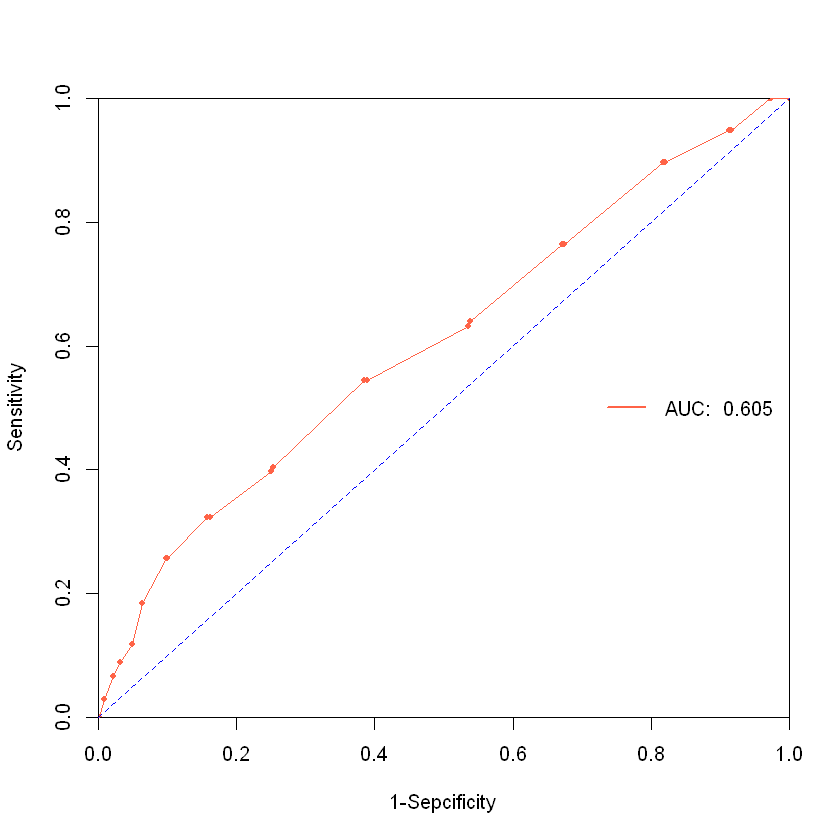

In [16]:
plot(1 - roc$specificities, 
     roc$sensitivities,
     pch = 20,
     col = "tomato", 
     xlim = c(0, 1), ylim = c(0, 1),
     xlab = '1-Sepcificity',
     ylab = 'Sensitivity',
     xaxs = 'i', 
     yaxs = 'i')
lines(1- roc$specificities, 
      roc$sensitivities,
      col = "tomato")
abline(0, 1, lty = 2, col = 'blue')
legend("right", 
       legend = paste("AUC: ", round(AUC, 3)), 
       col = "tomato", 
       lwd = 2, 
       bty = "n")

# Step 3: Model tuning

## Random split

In [17]:
# using the for loop 
results <- data.frame()
suppressMessages(for(k in 1:300) {
    KNN_fit <-
        knn(
            train = train[, -1],
            test = test[, -1],
            cl = train$AKI_binary,
            k = k,
            prob = TRUE
        )
    pred_prob <- attr(KNN_fit, 'prob')
    pred_prob <- ifelse(KNN_fit == 'yes', pred_prob, 1-pred_prob)

    # AUC 
    roc <- roc(as.factor(as.numeric(test$AKI_binary) - 1), pred_prob)
    AUC <- auc(roc)

    result <- data.frame(k = k, AUC = AUC)
    results <- rbind(results, result)
})

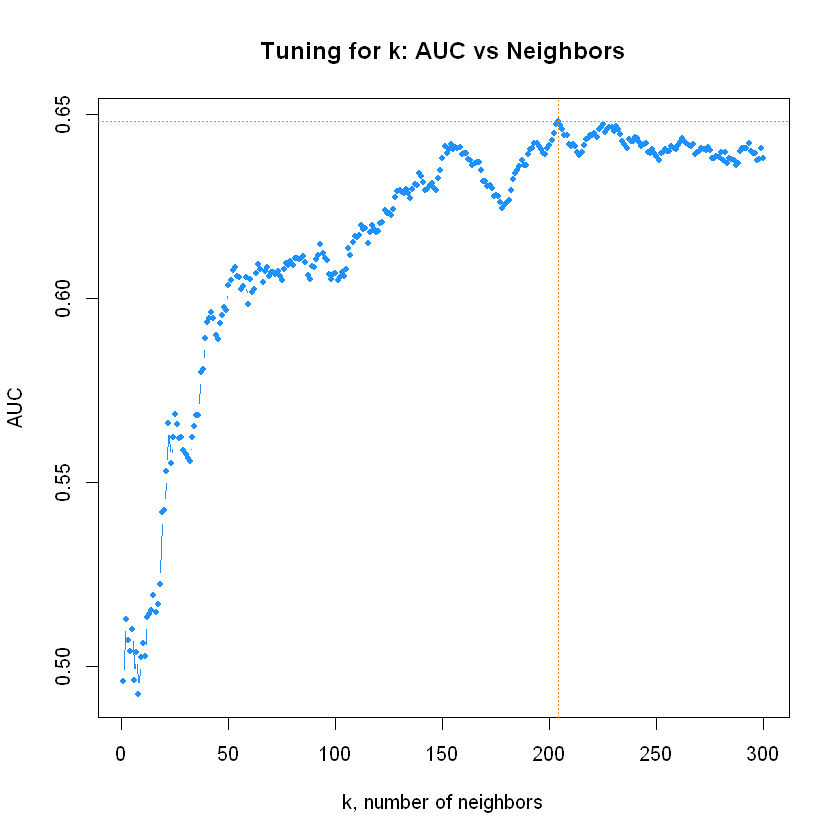

In [18]:
plot(results, 
    type = "b", 
    col = "dodgerblue", 
    cex = 1, 
    pch = 20, 
    xlab = "k, number of neighbors", 
    ylab = "AUC",
    main = "Tuning for k: AUC vs Neighbors")
# add line for max AUC seen
abline(h = max(results$AUC), col = "darkorange", lty = 3)
abline(v = results$k[results$AUC == max(results$AUC)], col = "darkorange", lty = 3)

## Cross-validation

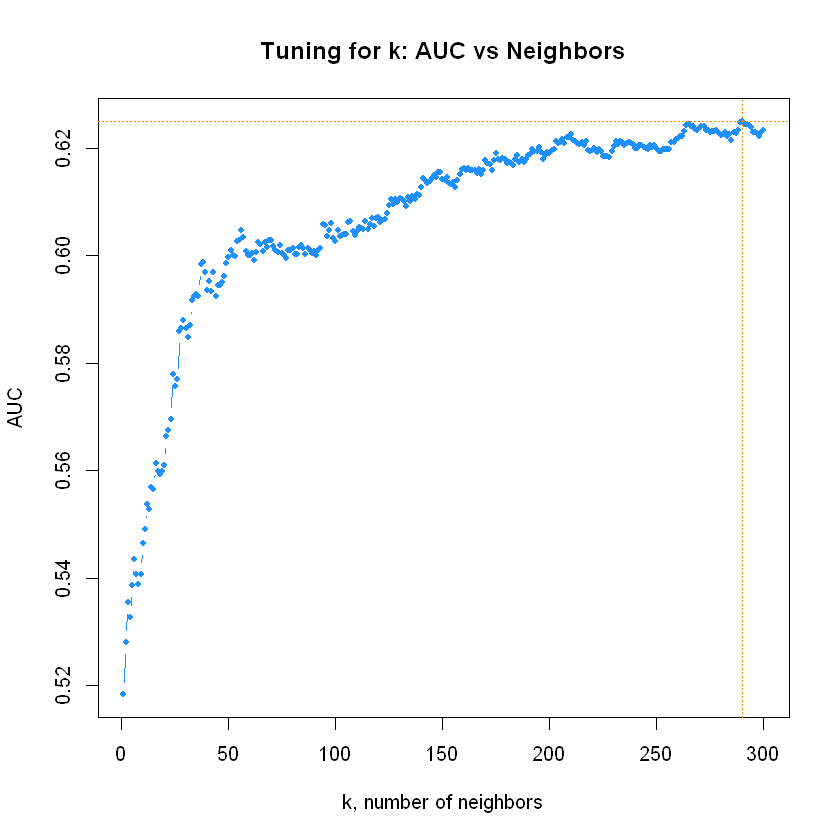

In [19]:
# Using caret package
ctrl <- trainControl(
            method = "cv",
            classProbs = TRUE,
            summaryFunction = twoClassSummary
        )
KNN_tune <- train(
                AKI_binary ~ ., 
                data = data_normalized, 
                method = "knn", 
                metric = "ROC",
                trControl = ctrl, 
                tuneGrid = data.frame(k = c(1:300))
		    )

plot(KNN_tune$results[, c('k', 'ROC')], 
    type = "b", 
    col = "dodgerblue", 
    cex = 1, 
    pch = 20, 
    xlab = "k, number of neighbors", 
    ylab = "AUC",
    main = "Tuning for k: AUC vs Neighbors")
# add line for max AUC seen
abline(h = max(KNN_tune$results$ROC), col = "darkorange", lty = 3)
abline(v = KNN_tune$results$k[KNN_tune$results$ROC == max(KNN_tune$results[['ROC']])], col = "darkorange", lty = 3)

# Step 4: Model refit

## Random split

In [20]:
best_model_k_split <- results$k[results$AUC == max(results$AUC)]
best_model_k_split

[1] 204

In [21]:
best_model_split <-
        knn(
            train = data_normalized[, -1],
            test = data_normalized[, -1],
            cl = data_normalized$AKI_binary,
            k = best_model_k_split,
            prob = TRUE
        )
pred_prob_split <- attr(best_model_split, 'prob')
pred_prob_split <- 
    ifelse(
        best_model_split == 'yes', 
        pred_prob_split, 
        1 - pred_prob_split
    )

In [22]:
# AUC 
roc_split <- roc(as.factor(
                    as.numeric(data_normalized$AKI_binary)- 1), 
                pred_prob_split)
AUC_split <- auc(roc_split)
AUC_split

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.6542

## Cross-validation

In [23]:
best_model_k_cv <- KNN_tune$bestTune$k
best_model_k_cv

[1] 290

In [24]:
best_model_cv <- 
    knn3(
        AKI_binary ~ .,
        data = data_normalized,
        k = best_model_k_cv
    )

predictions_cv <- predict(best_model_cv, data_normalized, type = "class")
pred_prob_cv <- predict(best_model_cv, data_normalized, type = "prob")
pred_prob_cv <- pred_prob_cv[,2]

In [25]:
# AUC 
roc_cv <- roc(as.factor(
                as.numeric(data_normalized$AKI_binary) - 1), 
              pred_prob_cv)
AUC_cv <- auc(roc_cv)
AUC_cv

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.6468

# Step 5: Model evaluation in external data

## Random split

In [26]:
best_model_external <-
        knn(
            train = data_normalized[, -1],
            test = data_external_normalized[, -1],
            cl = data_normalized$AKI_binary,
            k = best_model_k_split,
            prob = TRUE
        )
pred_prob <- attr(best_model_external, 'prob')
pred_prob <- ifelse(best_model_external == 'yes', pred_prob, 1-pred_prob)

In [27]:
# confusion matrix
cm <- table(actual = data_external_normalized$AKI_binary, predicted = best_model_external)
cm

      predicted
actual   no  yes
   no  2733    0
   yes  267    0

In [28]:
# AUC 
roc <- roc(data_external$AKI_binary, pred_prob)
AUC <- auc(roc)
AUC

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.6836

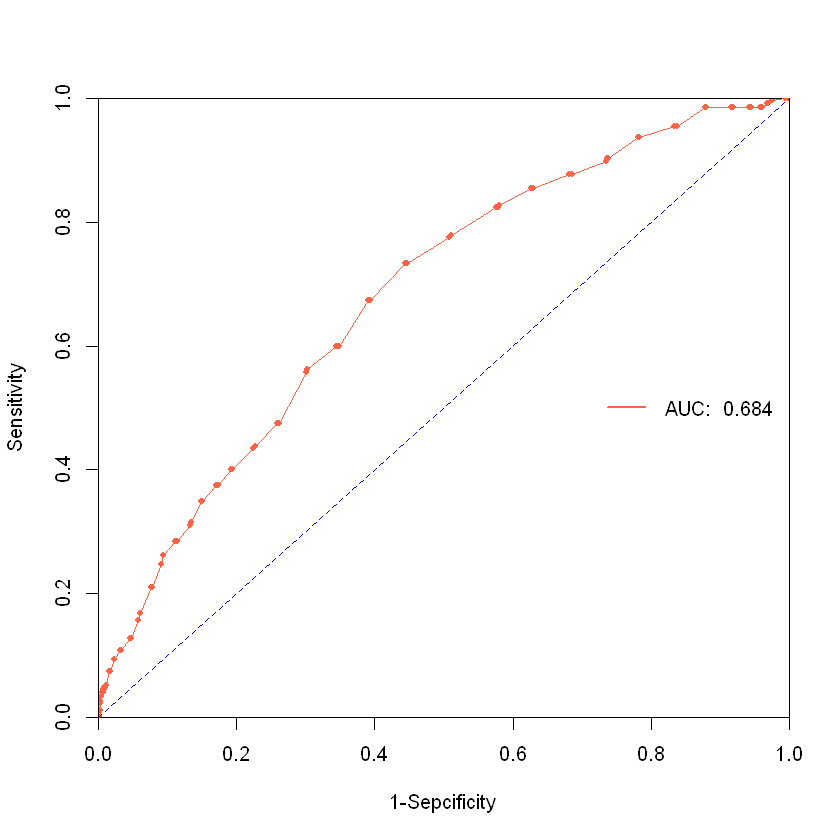

In [29]:
plot(1 - roc$specificities, 
     roc$sensitivities,
     pch = 20,
     col = "tomato", 
     xlim = c(0, 1), ylim = c(0, 1),
     xlab = '1-Sepcificity',
     ylab = 'Sensitivity',
     xaxs = 'i', 
     yaxs = 'i')
lines(1- roc$specificities, 
      roc$sensitivities,
      col = "tomato")
abline(0, 1, lty = 2, col = 'blue')
legend("right", 
       legend = paste("AUC: ", round(AUC, 3)), 
       col = "tomato", 
       lwd = 2, 
       bty = "n")

In [30]:
png(filename = 'roc_split.png', width = 1600, height = 1600, unit = 'px', res = 300)
plot(1 - roc$specificities, 
     roc$sensitivities,
     pch = 20,
     col = "tomato", 
     xlim = c(0, 1), ylim = c(0, 1),
     xlab = '1-Sepcificity',
     ylab = 'Sensitivity',
     xaxs = 'i', 
     yaxs = 'i')
lines(1- roc$specificities, 
      roc$sensitivities,
      col = "tomato")
abline(0, 1, lty = 2, col = 'blue')
legend("right", 
       legend = paste("AUC: ", round(AUC, 3)), 
       col = "tomato", 
       lwd = 2, 
       bty = "n")
dev.off()

png 
  2

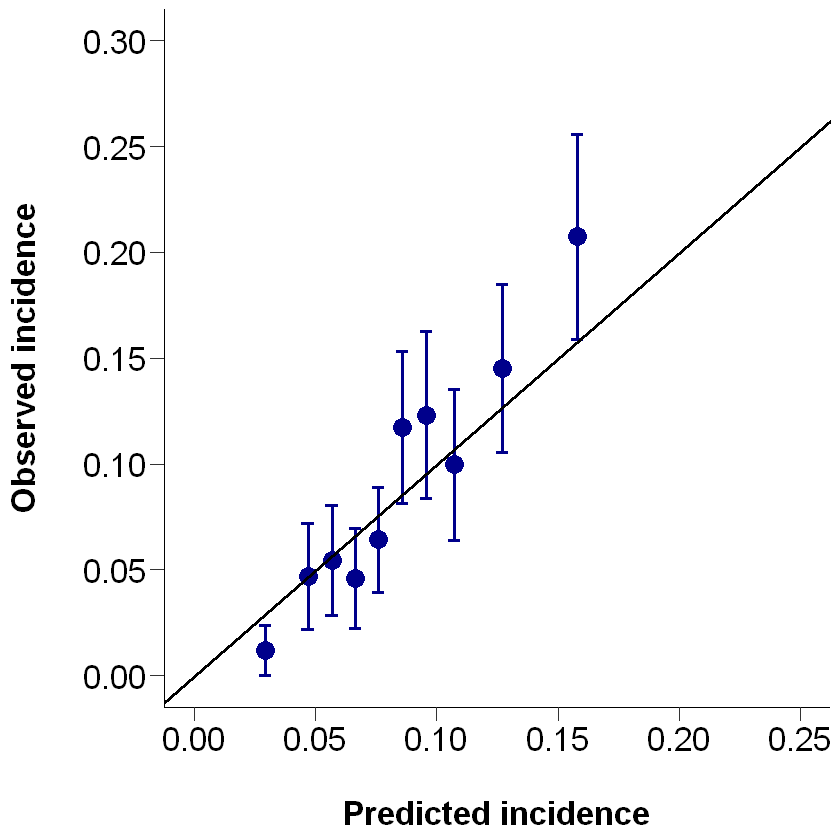

In [31]:
# calibration curve
n_group <- 10
cal_data <- data.frame(AKI_binary = as.numeric(data_external$AKI_binary) - 1, pred_prob)
cal_data <- cal_data[order(cal_data$pred_prob),]
cal_data <- cal_data %>% mutate(tiles = cut2(pred_prob, g = n_group))
cal_data <- cal_data %>% 
            group_by(tiles) %>% 
            summarise(
                n = n(),
                obs_mean = mean(AKI_binary),
                obs_sd = sd(AKI_binary),
                # obs_mean = sum(AKI_binary) / n(),
                # obs_sd = sqrt(obs_mean * (1 - obs_mean)),
                pred_mean = mean(pred_prob),
                obs_upper = obs_mean + 1.96*obs_sd/sqrt(n()),
                obs_lower = obs_mean - 1.96*obs_sd/sqrt(n())
            )

cal_plot <- 
    ggplot(
        cal_data, 
        aes(x = pred_mean, y = obs_mean)) +
    # geom_line() +
    geom_point(size = 5, colour = 'darkblue') +
    geom_errorbar(
        aes(ymin = obs_lower, ymax = obs_upper), 
        linewidth = 1,
        width = .005, 
        colour = 'darkblue'
    ) +
    geom_abline(linewidth = 1) +
    xlab("\nPredicted incidence") +
    ylab("Observed incidence\n") +
    scale_x_continuous(limits = c(0, 0.25), breaks = seq(0, 0.5, 0.05)) +
    scale_y_continuous(limits = c(0, 0.3), breaks = seq(0, 0.5, 0.05)) +
    theme(
        panel.background = element_blank(),
        panel.grid = element_blank(),
        # panel.grid.major.y = element_line(color = "gray"),
        plot.title = element_text(size = 20, face = "bold", hjust = 0), 
        axis.title = element_text(size = 20, face = "bold"),
        axis.text = element_text(size = 20, color = 'black'),
        axis.ticks.length.x = unit(0.3, 'cm'),
        axis.ticks.length.y = unit(0.3, 'cm'),
        axis.line = element_line(colour = "black", linewidth = 0.5)
    )
cal_plot

In [32]:
png(filename = 'calibration_curve_split.png', width = 3200, height = 3200, unit = 'px', res = 300)
cal_plot
dev.off()

png 
  2

## Cross-validation

In [33]:
best_model_external <-
        knn(
            train = data_normalized[, -1],
            test = data_external_normalized[, -1],
            cl = data_normalized$AKI_binary,
            k = best_model_k_cv,
            prob = TRUE
        )
pred_prob <- attr(best_model_external, 'prob')
pred_prob <- ifelse(best_model_external == 'yes', pred_prob, 1-pred_prob)

In [35]:
# confusion matrix
cm <- table(actual = data_external$AKI_binary, predicted = best_model_external)
cm

      predicted
actual   no  yes
     0 2733    0
     1  267    0

In [36]:
# AUC 
roc <- roc(data_external$AKI_binary, pred_prob)
AUC <- auc(roc)
AUC

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.6851

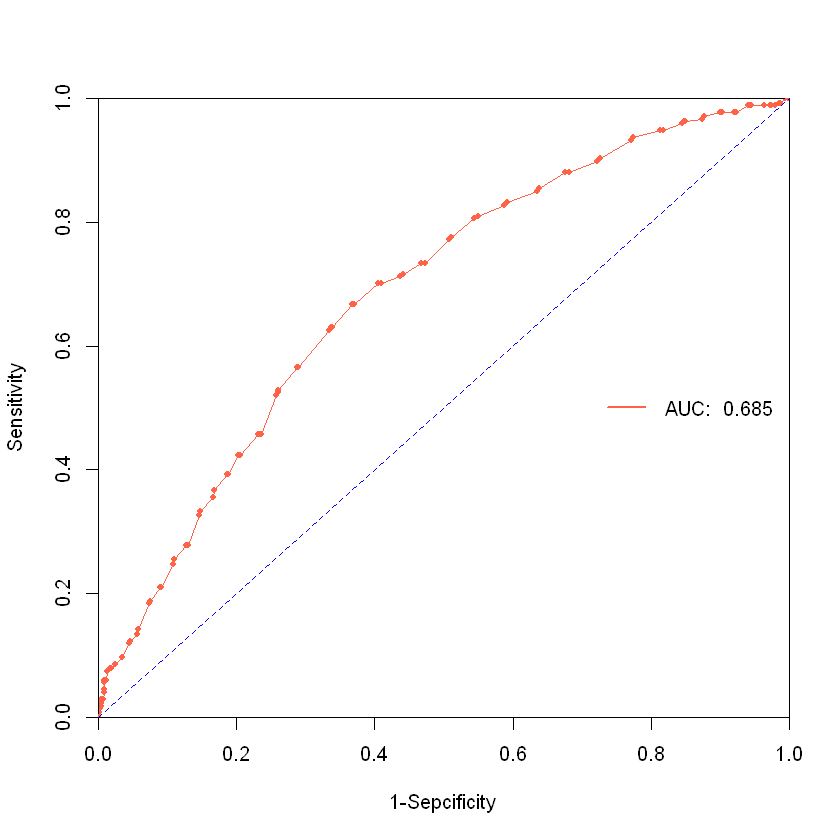

In [37]:
plot(1 - roc$specificities, 
     roc$sensitivities,
     pch = 20,
     col = "tomato", 
     xlim = c(0, 1), ylim = c(0, 1),
     xlab = '1-Sepcificity',
     ylab = 'Sensitivity',
     xaxs = 'i', 
     yaxs = 'i')
lines(1- roc$specificities, 
      roc$sensitivities,
      col = "tomato")
abline(0, 1, lty = 2, col = 'blue')
legend("right", 
       legend = paste("AUC: ", round(AUC, 3)), 
       col = "tomato", 
       lwd = 2, 
       bty = "n")

In [38]:
png(filename = 'roc_cv.png', width = 1600, height = 1600, unit = 'px', res = 300)
plot(1 - roc$specificities, 
     roc$sensitivities,
     pch = 20,
     col = "tomato", 
     xlim = c(0, 1), ylim = c(0, 1),
     xlab = '1-Sepcificity',
     ylab = 'Sensitivity',
     xaxs = 'i', 
     yaxs = 'i')
lines(1- roc$specificities, 
      roc$sensitivities,
      col = "tomato")
abline(0, 1, lty = 2, col = 'blue')
legend("right", 
       legend = paste("AUC: ", round(AUC, 3)), 
       col = "tomato", 
       lwd = 2, 
       bty = "n")
dev.off()

png 
  2

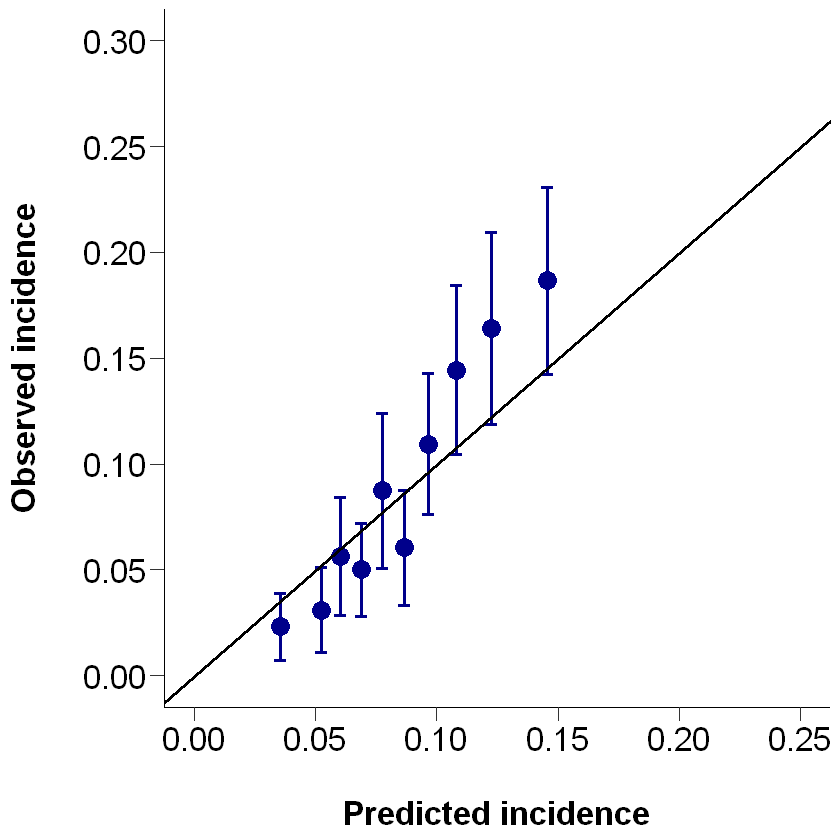

In [39]:
# calibration curve
n_group <- 10
cal_data <- data.frame(AKI_binary = as.numeric(data_external$AKI_binary) - 1, pred_prob)
cal_data <- cal_data[order(cal_data$pred_prob),]
cal_data <- cal_data %>% mutate(tiles = cut2(pred_prob, g = n_group))
cal_data <- cal_data %>% 
            group_by(tiles) %>% 
            summarise(
                n = n(),
                obs_mean = mean(AKI_binary),
                obs_sd = sd(AKI_binary),
                # obs_mean = sum(AKI_binary) / n(),
                # obs_sd = sqrt(obs_mean * (1 - obs_mean)),
                pred_mean = mean(pred_prob),
                obs_upper = obs_mean + 1.96*obs_sd/sqrt(n()),
                obs_lower = obs_mean - 1.96*obs_sd/sqrt(n())
            )

cal_plot <- 
    ggplot(
        cal_data, 
        aes(x = pred_mean, y = obs_mean)) +
    # geom_line() +
    geom_point(size = 5, colour = 'darkblue') +
    geom_errorbar(
        aes(ymin = obs_lower, ymax = obs_upper), 
        linewidth = 1,
        width = .005, 
        colour = 'darkblue'
    ) +
    geom_abline(linewidth = 1) +
    xlab("\nPredicted incidence") +
    ylab("Observed incidence\n") +
    scale_x_continuous(limits = c(0, 0.25), breaks = seq(0, 0.5, 0.05)) +
    scale_y_continuous(limits = c(0, 0.3), breaks = seq(0, 0.5, 0.05)) +
    theme(
        panel.background = element_blank(),
        panel.grid = element_blank(),
        # panel.grid.major.y = element_line(color = "gray"),
        plot.title = element_text(size = 20, face = "bold", hjust = 0), 
        axis.title = element_text(size = 20, face = "bold"),
        axis.text = element_text(size = 20, color = 'black'),
        axis.ticks.length.x = unit(0.3, 'cm'),
        axis.ticks.length.y = unit(0.3, 'cm'),
        axis.line = element_line(colour = "black", linewidth = 0.5)
    )
cal_plot

In [40]:
png(filename = 'calibration_curve_cv.png', width = 3200, height = 3200, unit = 'px', res = 300)
cal_plot
dev.off()

png 
  2